In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/shared_articles.csv
/kaggle/input/users_interactions.csv


In [2]:
import random
import sklearn
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

In [3]:
shared_articles=pd.read_csv('/kaggle/input/shared_articles.csv')
user_interactions=pd.read_csv('/kaggle/input/users_interactions.csv')

In [4]:
print(shared_articles.head(10))
print(user_interactions.head(10))

    timestamp        eventType            contentId       authorPersonId  \
0  1459192779  CONTENT REMOVED -6451309518266745024  4340306774493623681   
1  1459193988   CONTENT SHARED -4110354420726924665  4340306774493623681   
2  1459194146   CONTENT SHARED -7292285110016212249  4340306774493623681   
3  1459194474   CONTENT SHARED -6151852268067518688  3891637997717104548   
4  1459194497   CONTENT SHARED  2448026894306402386  4340306774493623681   
5  1459194522   CONTENT SHARED -2826566343807132236  4340306774493623681   
6  1459194557   CONTENT SHARED -2148899391355011268  4340306774493623681   
7  1459194599   CONTENT SHARED  4119190424078847945  4340306774493623681   
8  1459194751   CONTENT SHARED -7926018713416777892  4340306774493623681   
9  1459194842   CONTENT SHARED  3353902017498793780  4340306774493623681   

       authorSessionId authorUserAgent authorRegion authorCountry contentType  \
0  8940341205206233829             NaN          NaN           NaN        HTML   
1

In [5]:
shared_articles=shared_articles[shared_articles['eventType']=='CONTENT SHARED']

In [6]:
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,  
}

user_interactions['eventStrength'] = user_interactions['eventType'].apply(lambda x: event_type_strength[x])

In [7]:
user_interactions

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry,eventStrength
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,1.0
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,1.0
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN,1.0
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN,3.0
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN,1.0
5,1465413742,VIEW,310515487419366995,-8763398617720485024,1395789369402380392,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,MG,BR,1.0
6,1465415950,VIEW,-8864073373672512525,3609194402293569455,1143207167886864524,NaN,NaN,NaN,1.0
7,1465415066,VIEW,-1492913151930215984,4254153380739593270,8743229464706506141,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,1.0
8,1465413762,VIEW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN,1.0
9,1465413771,VIEW,3064370296170038610,3609194402293569455,1143207167886864524,NaN,NaN,NaN,1.0


In [8]:
count_user_interactions=user_interactions.groupby(["contentId","personId"]).size().groupby(['personId']).size()

In [9]:
len(count_user_interactions)

1895

In [10]:
enough_interaction_users=count_user_interactions[count_user_interactions>=5].reset_index()[["personId"]]

In [11]:
interactions_with_min_5=user_interactions.merge(enough_interaction_users,how='right',left_on='personId',right_on='personId')

In [12]:
interactions_with_min_5

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry,eventStrength
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,1.0
1,1465413046,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5...,SP,BR,1.0
2,1464190235,VIEW,6437568358552101410,-8845298781299428018,-1157447994463607871,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,SP,BR,1.0
3,1459429221,VIEW,-4760639635023250284,-8845298781299428018,-5149610736659242149,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,SP,BR,1.0
4,1459274156,VIEW,-6142462826726347616,-8845298781299428018,-6283148774987755959,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,SP,BR,1.0
5,1459274266,VIEW,-1672166631728511207,-8845298781299428018,-6283148774987755959,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,SP,BR,1.0
6,1459274282,VIEW,-1672166631728511207,-8845298781299428018,-6283148774987755959,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,SP,BR,1.0
7,1464878692,VIEW,2601622077116449484,-8845298781299428018,-5332595842923867237,NaN,NaN,NaN,1.0
8,1464878692,VIEW,2601622077116449484,-8845298781299428018,-5332595842923867237,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5...,SP,BR,1.0
9,1465481798,LIKE,8890720798209849691,-8845298781299428018,2199204395214244565,NaN,NaN,NaN,2.0


In [13]:
import math
def smooth_user_preference(x):
    return math.log(1+x, 2)

In [14]:
interactions_full_df=interactions_with_min_5.groupby(['personId', 'contentId'])['eventStrength'].sum().apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head(10)

# of unique user/item interactions: 39106


,personId,contentId,eventStrength
0,-9223121837663643404,-8949113594875411859,1.000000
1,-9223121837663643404,-8377626164558006982,1.000000
2,-9223121837663643404,-8208801367848627943,1.000000
3,-9223121837663643404,-8187220755213888616,1.000000
4,-9223121837663643404,-7423191370472335463,3.169925
5,-9223121837663643404,-7331393944609614247,1.000000
6,-9223121837663643404,-6872546942144599345,1.000000
7,-9223121837663643404,-6728844082024523434,1.000000
8,-9223121837663643404,-6590819806697898649,1.000000
9,-9223121837663643404,-6558712014192834002,1.584963


In [15]:
from sklearn.model_selection import train_test_split
interactions_train,interactions_test=train_test_split(interactions_full_df,stratify=interactions_full_df['personId'],test_size=0.20,random_state=42)

In [16]:
interactions_full_indexed_df = interactions_full_df.set_index('personId')
interactions_train_indexed_df = interactions_train.set_index('personId')
interactions_test_indexed_df = interactions_test.set_index('personId')

In [17]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    interacted_items = interactions_df.loc[person_id]['contentId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [18]:
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:
    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(user_interactions['contentId'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id,items_to_ignore=get_items_interacted(person_id,interactions_train_indexed_df),topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['contentId'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator() 


In [19]:
item_popularity_df = interactions_full_df.groupby('contentId')['eventStrength'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(10)

,contentId,eventStrength
0,-4029704725707465084,307.733799
1,-6783772548752091658,233.762157
2,-133139342397538859,228.024567
3,-8208801367848627943,197.107608
4,-6843047699859121724,193.825208
5,8224860111193157980,189.044680
6,-2358756719610361882,183.110951
7,2581138407738454418,180.282876
8,7507067965574797372,179.094002
9,1469580151036142903,170.548969


In [20]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['contentId'].isin(items_to_ignore)].sort_values('eventStrength', ascending = False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['eventStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, user_interactions)

In [21]:
global_pop_mterics, detailed_pop_results_df = model_evaluator.evaluate_model(popularity_model)
detailed_pop_results_df.head(10)

1139 users processed


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
76,3609194402293569455,46,24,192,0.239583,0.125000
17,-2626634673110551643,24,11,134,0.179104,0.082090
16,-1032019229384696495,25,16,130,0.192308,0.123077
10,-1443636648652872475,5,3,117,0.042735,0.025641
82,-2979881261169775358,36,27,88,0.409091,0.306818
161,-3596626804281480007,18,10,80,0.225000,0.125000
65,1116121227607581999,31,19,73,0.424658,0.260274
81,692689608292948411,21,12,69,0.304348,0.173913
106,-9016528795238256703,18,15,69,0.260870,0.217391
52,3636910968448833585,28,19,68,0.411765,0.279412


In [22]:
print(global_pop_mterics)

{'modelName': 'Popularity', 'recall@5': 0.23830222449501406, 'recall@10': 0.3681922781897213}


In [23]:
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')

#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = shared_articles['contentId'].tolist()
tfidf_matrix = vectorizer.fit_transform(shared_articles['title'] + "" + shared_articles['text'])
tfidf_feature_names = vectorizer.get_feature_names()

In [24]:
import scipy
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'])
    
    user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_full_df[interactions_full_df['contentId'].isin(shared_articles['contentId'])].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [25]:
user_profiles = build_users_profiles()
len(user_profiles)

1140

In [26]:
myprofile = user_profiles[-1479311724257856983]
print(myprofile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles[-1479311724257856983].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

(1, 5000)


,token,relevance
0,learning,0.305655
1,machine learning,0.255557
2,machine,0.246095
3,google,0.208590
4,data,0.172509
5,ai,0.136818
6,algorithms,0.102396
7,graph,0.098438
8,like,0.096970
9,language,0.083993


In [27]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['contentId', 'recStrength']).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(shared_articles)

In [28]:
a=[1,2,3,4,5,6,7,8]
print(a[-3:])

[6, 7, 8]


In [29]:
global_cb_mterics, detailed_cb_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
detailed_cb_results_df.head(10)

1139 users processed


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
76,3609194402293569455,31,19,192,0.161458,0.098958
17,-2626634673110551643,34,24,134,0.253731,0.179104
16,-1032019229384696495,34,22,130,0.261538,0.169231
10,-1443636648652872475,50,33,117,0.427350,0.282051
82,-2979881261169775358,16,6,88,0.181818,0.068182
161,-3596626804281480007,25,18,80,0.312500,0.225000
65,1116121227607581999,14,9,73,0.191781,0.123288
81,692689608292948411,18,15,69,0.260870,0.217391
106,-9016528795238256703,13,6,69,0.188406,0.086957
52,3636910968448833585,10,3,68,0.147059,0.044118


In [30]:
print(global_cb_mterics)

{'modelName': 'Content-Based', 'recall@5': 0.41613398107900795, 'recall@10': 0.5232677064689337}


In [31]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train.pivot(index='personId', 
                                                          columns='contentId', 
                                                          values='eventStrength').fillna(0)

users_items_pivot_matrix_df.head(10)

contentId,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9176143510534135851,-9172673334835262304,-9171475473795142532,-9166778629773133902,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
personId,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9212075797126931087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9207251133131336884,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9199575329909162940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9196668942822132778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9188188261933657343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9172914609055320039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9156344805277471150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9120685872592674274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
users_items_pivot_matrix = users_items_pivot_matrix_df.values
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [33]:
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

In [34]:
print(U.shape)
print(Vt.shape)
sigma = np.diag(sigma)
print(sigma.shape)

(1140, 15)
(15, 2926)
(15, 15)


In [35]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings
print(all_user_predicted_ratings.shape)

(1140, 2926)


In [36]:
users_ids = list(users_items_pivot_matrix_df.index)
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,-9223121837663643404,-9212075797126931087,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,...,9105269044962898535,9109075639526981934,9135582630122950040,9137372837662939523,9148269800512008413,9165571805999894845,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
contentId,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,0.010399,-0.000193,-0.012547,0.052958,-0.010035,-0.005412,-0.003918,0.049302,-0.013458,-0.020052,...,-0.005306,-0.089463,-0.000048,0.015023,0.020953,-0.009394,-0.019114,-0.029954,-0.018455,-0.015064
-9216926795620865886,0.000819,-0.000313,0.006595,-0.000649,0.000151,0.000338,0.000197,0.000861,0.002341,0.001765,...,0.000095,0.013915,0.000506,0.001460,0.014863,0.000940,0.002391,0.008057,0.004670,0.003277
-9194572880052200111,-0.017253,-0.002646,-0.005907,-0.003666,0.021300,-0.001278,0.029100,-0.014730,-0.023410,0.004950,...,0.011529,0.046012,0.010485,0.018768,0.150362,0.019052,0.023870,-0.018463,0.012196,0.133913
-9192549002213406534,0.035081,0.000391,-0.029046,-0.007702,0.017615,0.005496,0.013435,0.057563,0.047532,0.004209,...,0.020149,0.260317,0.007923,-0.008079,0.034164,0.011558,0.013793,-0.010138,0.025703,0.095753
-9190737901804729417,0.019939,-0.004799,0.006684,0.006363,-0.001997,0.002356,0.003876,0.004118,-0.027098,0.019793,...,0.003719,0.004478,0.001917,0.000341,-0.034535,-0.001160,0.001307,0.002957,0.005991,-0.015662
-9189659052158407108,0.008661,0.006604,0.001463,-0.002918,0.008551,-0.001637,0.005443,0.002193,0.023148,0.021311,...,0.024496,0.090091,-0.002703,0.001883,0.098925,0.008484,0.014513,0.016385,0.021794,0.068420
-9176143510534135851,0.046426,0.006374,0.013802,0.010265,-0.002538,-0.004453,0.016615,0.023070,0.059582,0.057307,...,0.003667,0.073024,-0.015438,0.001199,-0.005606,-0.000307,0.005250,0.041064,0.030733,0.037113
-9172673334835262304,0.005083,0.000618,0.002845,-0.001103,0.000398,0.000754,0.001346,0.002713,-0.002811,0.003930,...,0.005625,0.019382,0.000544,-0.000992,-0.008110,0.000156,0.003408,0.003614,0.007607,-0.003650
-9171475473795142532,0.024453,-0.000761,0.000963,-0.002817,0.002466,0.001215,0.009339,-0.003530,-0.007137,0.023221,...,0.009667,0.017163,0.000424,0.000060,-0.016698,0.002045,0.007644,0.000955,0.011074,-0.006657


In [37]:
cf_preds_df.shape

(2926, 1140)

In [38]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, shared_articles)

In [39]:
global_cf_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print(global_cf_metrics)
cf_detailed_results_df.head(10)

1139 users processed
{'modelName': 'Collaborative Filtering', 'recall@5': 0.3295832267962158, 'recall@10': 0.4619023267706469}


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
76,3609194402293569455,43,19,192,0.223958,0.098958
17,-2626634673110551643,54,28,134,0.402985,0.208955
16,-1032019229384696495,33,21,130,0.253846,0.161538
10,-1443636648652872475,57,38,117,0.487179,0.324786
82,-2979881261169775358,49,31,88,0.556818,0.352273
161,-3596626804281480007,30,19,80,0.375000,0.237500
65,1116121227607581999,36,20,73,0.493151,0.273973
81,692689608292948411,25,15,69,0.362319,0.217391
106,-9016528795238256703,30,18,69,0.434783,0.260870
52,3636910968448833585,28,21,68,0.411765,0.308824


In [40]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        
        #Combining the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'inner', 
                                   left_on = 'contentId', 
                                   right_on = 'contentId')
        
        #Computing a hybrid recommendation score based on CF and CB scores
        recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF']
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrengthHybrid', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, shared_articles)

In [41]:
global_hb_metrics, detailed_hb_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print(global_hb_metrics)
detailed_hb_results_df.head(10)

1139 users processed
{'modelName': 'Collaborative Filtering', 'recall@5': 0.3295832267962158, 'recall@10': 0.4619023267706469}


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
76,3609194402293569455,43,19,192,0.223958,0.098958
17,-2626634673110551643,54,28,134,0.402985,0.208955
16,-1032019229384696495,33,21,130,0.253846,0.161538
10,-1443636648652872475,57,38,117,0.487179,0.324786
82,-2979881261169775358,49,31,88,0.556818,0.352273
161,-3596626804281480007,30,19,80,0.375000,0.237500
65,1116121227607581999,36,20,73,0.493151,0.273973
81,692689608292948411,25,15,69,0.362319,0.217391
106,-9016528795238256703,30,18,69,0.434783,0.260870
52,3636910968448833585,28,21,68,0.411765,0.308824


In [42]:
global_metrics_df = pd.DataFrame([global_pop_mterics, global_cb_mterics, global_cf_metrics, global_hb_metrics]).set_index('modelName')
global_metrics_df

,recall@10,recall@5
modelName,,
Popularity,0.368192,0.238302
Content-Based,0.523268,0.416134
Collaborative Filtering,0.461902,0.329583
Collaborative Filtering,0.461902,0.329583


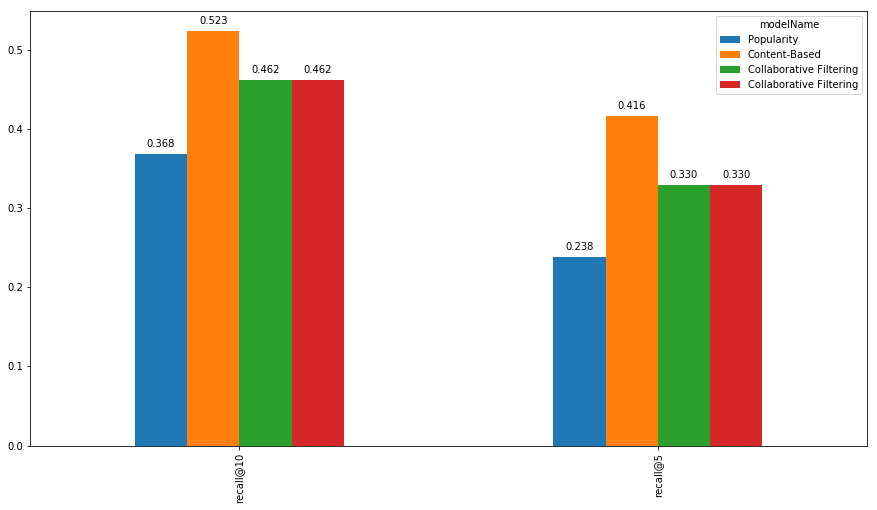

In [43]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [44]:
def inspect_interactions(person_id, test_set=True):
    if test_set:
        interactions_df = interactions_test_indexed_df
    else:
        interactions_df = interactions_train_indexed_df
    return interactions_df.loc[person_id].merge(shared_articles, how = 'left', 
                                                      left_on = 'contentId', 
                                                      right_on = 'contentId').sort_values('eventStrength', ascending = False)[['eventStrength','contentId','title', 'url', 'lang']]

In [45]:
inspect_interactions(-1479311724257856983, test_set=False).head(20)

,eventStrength,contentId,title,url,lang
115,4.285402,7342707578347442862,"At eBay, Machine Learning is Driving Innovativ...",https://www.ebayinc.com/stories/news/at-ebay-m...,en
38,4.129283,621816023396605502,AI Is Here to Help You Write Emails People Wil...,http://www.wired.com/2016/08/boomerang-using-a...,en
8,4.044394,-4460374799273064357,"Deep Learning for Chatbots, Part 1 - Introduction",http://www.wildml.com/2016/04/deep-learning-fo...,en
116,3.954196,-7959318068735027467,Auto-scaling scikit-learn with Spark,https://databricks.com/blog/2016/02/08/auto-sc...,en
10,3.906891,2589533162305407436,6 reasons why I like KeystoneML,http://radar.oreilly.com/2015/07/6-reasons-why...,en
28,3.700440,5258604889412591249,Machine Learning Is No Longer Just for Experts,https://hbr.org/2016/10/machine-learning-is-no...,en
6,3.700440,-398780385766545248,10 Stats About Artificial Intelligence That Wi...,http://www.fool.com/investing/2016/06/19/10-st...,en
113,3.643856,-6467708104873171151,5 reasons your employees aren't sharing their ...,http://justcuriousblog.com/2016/04/5-reasons-y...,en
42,3.523562,-4944551138301474550,Algorithms and architecture for job recommenda...,https://www.oreilly.com/ideas/algorithms-and-a...,en
43,3.459432,-8377626164558006982,Bad Writing Is Destroying Your Company's Produ...,https://hbr.org/2016/09/bad-writing-is-destroy...,en


In [46]:
hybrid_recommender_model.recommend_items(-1479311724257856983, topn=20, verbose=True)

,recStrengthHybrid,contentId,title,url,lang
0,0.484696,3269302169678465882,The barbell effect of machine learning.,http://techcrunch.com/2016/06/02/the-barbell-e...,en
1,0.428711,5092635400707338872,Power to the People: How One Unknown Group of ...,https://medium.com/@atduskgreg/power-to-the-pe...,en
2,0.411263,5258604889412591249,Machine Learning Is No Longer Just for Experts,https://hbr.org/2016/10/machine-learning-is-no...,en
3,0.358686,-9033211547111606164,Google's Cloud Machine Learning service is now...,https://techcrunch.com/2016/09/29/googles-clou...,en
4,0.335053,5250363310227021277,"How Google is Remaking Itself as a ""Machine Le...",https://backchannel.com/how-google-is-remaking...,en
5,0.316371,-7126520323752764957,"How Google is Remaking Itself as a ""Machine Le...",https://backchannel.com/how-google-is-remaking...,en
6,0.316029,7395435905985567130,The AI business landscape,https://www.oreilly.com/ideas/the-ai-business-...,en
7,0.309052,-5756697018315640725,Being A Developer After 40 - Free Code Camp,https://medium.freecodecamp.com/being-a-develo...,en
8,0.295994,-8190931845319543363,Machine Learning Is At The Very Peak Of Its Hy...,https://arc.applause.com/2016/08/17/gartner-hy...,en
9,0.294210,1415230502586719648,Machine Learning Is Redefining The Enterprise ...,http://www.forbes.com/sites/louiscolumbus/2016...,en
